In [1]:
import pandas as pd
import datetime as dt
from scipy.stats import zscore
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

## Import

In [2]:
engine = create_engine('sqlite:///Data/raw/mta_data.db')
mta = pd.read_sql('SELECT * FROM mta_data WHERE (TIME <"08" OR TIME >="20") AND (substr(DATE,1,2) =="06" OR substr(DATE,1,2) =="07" OR substr(DATE,1,2) =="08") AND (substr(DATE,9,2) =="20");', engine)

In [3]:
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/29/2020,00:00:00,REGULAR,7450785,2533372
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/29/2020,04:00:00,REGULAR,7450788,2533375
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/29/2020,20:00:00,REGULAR,7451020,2533470
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/30/2020,00:00:00,REGULAR,7451092,2533482
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/30/2020,04:00:00,REGULAR,7451095,2533482


In [4]:
#mta = pd.read_csv('Data/raw/2021.csv')
zip_boro_station = pd.read_csv('Data/Processed/zip_boro_geo.csv',dtype={'ZIP':'object'})

Merge to filter for stations in Brooklyn and Manhattan only

In [5]:
mta['STATION'] = (mta.STATION.str.strip().str.replace('AVE','AV')
                              .str.replace('STREET','ST').str.replace('COLLEGE','CO')
                              .str.replace('SQUARE','SQ').replace('STS','ST').replace('/','-'))
df = (mta.merge(zip_boro_station.loc[:,['STATION','BOROUGH']], on='STATION'))
df = df[(df.BOROUGH=='Manhattan')|(df.BOROUGH=='Brooklyn')]

In [6]:
# Convert to datetime
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df["DATE"] = pd.to_datetime(df.DATE, format="%m/%d/%Y")
df["TIME"] = pd.to_datetime(df.TIME)

#### Drop Duplicates
It seems the RECOVER AUD entries are irregular, so we will drop them when they have REGULAR homologue (or duplicate).

In [7]:
# Check for duplicates
duplicates_count = (df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))
print(duplicates_count.value_counts('ENTRIES'))
# Drop duplicates
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"]).ENTRIES.count().value_counts()
# Drop Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
df = df.drop(["DESC","EXITS"], axis=1, errors="ignore")

ENTRIES
1    894908
2      2767
dtype: int64


#### Get late-night entries only

Look at timestamps, we want the late-night entries instead of hourly cumulative. 
Compare the first stamp of the evening against the last stamp of the early morning, dropping the day we don't have a comparison for (last).

In [8]:
evening = df[df.TIME.dt.time > dt.time(19,59)]
morning = df[df.TIME.dt.time < dt.time(4,1)]
first_stamp = (evening.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])
                        .ENTRIES.first())
last_stamp = (morning.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])
                        .ENTRIES.last())
timestamps = pd.merge(first_stamp, last_stamp, on=["C/A", "UNIT", "SCP", "STATION", "DATE"], suffixes=['_CUM_AM','_CUM_PM'])
timestamps.reset_index(inplace=True)

In [9]:
timestamps['ENTRIES_CUM_AM'] = (timestamps.groupby(["C/A", "UNIT", "SCP", "STATION"])
                        .ENTRIES_CUM_AM.shift(-1))
# Drop Sundays, where we don't have data from the next morning.
timestamps.dropna(subset=['ENTRIES_CUM_AM'], inplace=True)
timestamps.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_CUM_AM,ENTRIES_CUM_PM
0,A002,R051,02-00-00,59 ST,2020-06-01,7420410.0,7420099
1,A002,R051,02-00-00,59 ST,2020-06-02,7420573.0,7420257
2,A002,R051,02-00-00,59 ST,2020-06-03,7420736.0,7420420
3,A002,R051,02-00-00,59 ST,2020-06-04,7420901.0,7420584
4,A002,R051,02-00-00,59 ST,2020-06-05,7421007.0,7420744


Get evening entries instead of cumulative. Getting the absolute value, since some of the turnstiles are counting backwards.

In [10]:
timestamps['ENTRIES'] = abs(timestamps.ENTRIES_CUM_AM - timestamps.ENTRIES_CUM_PM)
timestamps.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_CUM_AM,ENTRIES_CUM_PM,ENTRIES
0,A002,R051,02-00-00,59 ST,2020-06-01,7420410.0,7420099,311.0
1,A002,R051,02-00-00,59 ST,2020-06-02,7420573.0,7420257,316.0
2,A002,R051,02-00-00,59 ST,2020-06-03,7420736.0,7420420,316.0
3,A002,R051,02-00-00,59 ST,2020-06-04,7420901.0,7420584,317.0
4,A002,R051,02-00-00,59 ST,2020-06-05,7421007.0,7420744,263.0


#### Get weekend data only
We are only interested in the weekends, so lets filter for those. I am doing this now so when we filter for outliers the mean will be more accurate (weekday entries skew the data).

In [11]:
timestamps['DAY_WEEK'] = timestamps.DATE.dt.dayofweek
weekend = timestamps[timestamps.DAY_WEEK.isin([3,4,5])]
weekend.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_CUM_AM,ENTRIES_CUM_PM,ENTRIES,DAY_WEEK
3,A002,R051,02-00-00,59 ST,2020-06-04,7420901.0,7420584,317.0,3
4,A002,R051,02-00-00,59 ST,2020-06-05,7421007.0,7420744,263.0,4
5,A002,R051,02-00-00,59 ST,2020-06-06,7421360.0,7420920,440.0,5
9,A002,R051,02-00-00,59 ST,2020-06-11,7422345.0,7421889,456.0,3
10,A002,R051,02-00-00,59 ST,2020-06-12,7422542.0,7422124,418.0,4


In [12]:
weekend.sort_values('ENTRIES', ascending=False).head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_CUM_AM,ENTRIES_CUM_PM,ENTRIES,DAY_WEEK
125571,N102,R127,01-00-05,JAY ST-METROTEC,2020-07-02,296.0,1246039075,1.246039e+09,3
227688,R185,R274,00-00-00,191 ST,2020-07-24,654375232.0,10317398,6.440578e+08,4
46565,C012,R258,01-06-00,4AV-9 ST,2020-07-11,223936549.0,167060,2.237695e+08,5
51311,C026,R215,01-06-01,86 ST,2020-07-18,393220.0,118199672,1.178065e+08,5
227777,R185,R274,00-00-01,191 ST,2020-07-24,67156245.0,10449556,5.670669e+07,4


#### Cleaning 

In [13]:
# Cleaning Functions
def max_counter(row, threshold):
    counter = row['ENTRIES']
    if counter < 0:
        counter = -counter
    if counter > threshold:
        counter = row['MEDIAN']
    if counter > threshold:
        counter = 0
    return counter

def outl_to_med(x):
    res = (x['ENTRIES']*x['~OUTLIER'])+(x['MEDIAN']*x['OUTLIER'])
    return res

In [14]:
# Replace outliers with the turnstile median
weekend['MEDIAN'] = (weekend.groupby(['C/A','UNIT','SCP','STATION'])
                .ENTRIES.transform(lambda x: x.median()))
weekend['OUTLIER'] = (weekend.groupby(['C/A','UNIT','SCP','STATION'])
                 .ENTRIES.transform(lambda x: zscore(x)>3))
weekend['~OUTLIER'] = weekend.OUTLIER.apply(lambda x:  not x)
weekend['ENTRIES'] = weekend.apply(outl_to_med, axis=1)

In [15]:
# There are still irregular values, set them to the updated median.
# If the median is still too high, replace with 0.
weekend['MEDIAN'] = (weekend.groupby(['C/A','UNIT','SCP','STATION'])
                .ENTRIES.transform(lambda x: x.median()))
weekend['ENTRIES'] = weekend.apply(max_counter, axis=1, threshold=3500)

In [16]:
print(weekend.MEDIAN.max())
weekend[weekend.ENTRIES>3000].shape

2421.0


(39, 12)

In [17]:
weekend.sort_values('ENTRIES', ascending=False).head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_CUM_AM,ENTRIES_CUM_PM,ENTRIES,DAY_WEEK,MEDIAN,OUTLIER,~OUTLIER
252249,R238,R046,00-06-02,GRD CNTRL-42 ST,2020-07-16,261529.0,258037,3492.0,3,527.0,False,True
266082,R251,R144,00-03-02,96 ST,2020-08-27,646050876.0,646047389,3487.0,3,2077.0,False,True
66305,H009,R235,00-03-03,BEDFORD AV,2020-08-14,12344851.0,12341371,3480.0,4,285.5,False,True
266068,R251,R144,00-03-02,96 ST,2020-08-13,646031026.0,646027596,3430.0,3,2077.0,False,True
266075,R251,R144,00-03-02,96 ST,2020-08-20,646040924.0,646037519,3405.0,3,2077.0,False,True


Drop unnecessary rows

In [18]:
weekend.drop(['MEDIAN','OUTLIER','~OUTLIER', 'ENTRIES_CUM_AM', 'ENTRIES_CUM_PM'], axis=1, inplace=True, errors='ignore')

Sanity Check: visualize to check for irregularities

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
weekend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125518 entries, 3 to 296341
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   C/A       125518 non-null  object        
 1   UNIT      125518 non-null  object        
 2   SCP       125518 non-null  object        
 3   STATION   125518 non-null  object        
 4   DATE      125518 non-null  datetime64[ns]
 5   ENTRIES   125518 non-null  float64       
 6   DAY_WEEK  125518 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 7.7+ MB


In [21]:
weekend['WEEK'] = weekend.DATE.dt.week

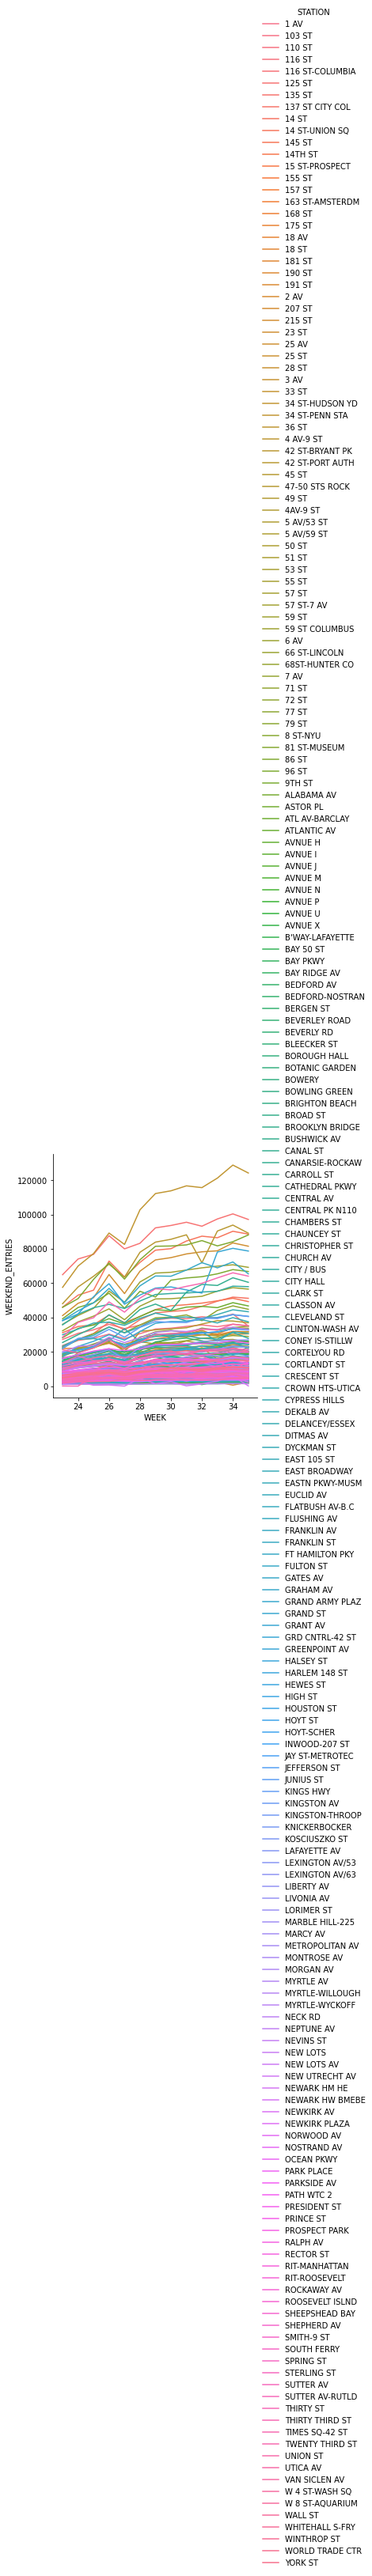

In [22]:
per_week_station = weekend.groupby(['STATION','WEEK'])['ENTRIES'].sum().reset_index()
per_week_station.rename(columns={'ENTRIES':"WEEKEND_ENTRIES"}, inplace=True)

sns.relplot(x='WEEK', y='WEEKEND_ENTRIES', data=per_week_station, kind='line', hue='STATION')
plt.show()

In [23]:
# Something is happening on week 26
# Upon closer inspection we can see that it corresponds with 4th July weekend.
# Many New Yorkers leave the city for that date, so it makes sense.
weekend[weekend.WEEK==26].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,DAY_WEEK,WEEK
23,A002,R051,02-00-00,59 ST,2020-06-25,730.0,3,26
24,A002,R051,02-00-00,59 ST,2020-06-26,628.0,4,26
25,A002,R051,02-00-00,59 ST,2020-06-27,406.0,5,26
113,A002,R051,02-00-01,59 ST,2020-06-25,498.0,3,26
114,A002,R051,02-00-01,59 ST,2020-06-26,402.0,4,26


### Export

In [24]:
weekend.to_csv('Data/Processed/weekend_20.csv', index=False)
weekend_geo = weekend.merge(zip_boro_station, on='STATION')
weekend_geo.to_csv('Data/Processed/weekend_geo_20.csv', index=False)

In [25]:
# Export the total by station with its corresponding coordinates. 
station_totals = weekend.groupby('STATION').ENTRIES.sum()\
    .reset_index().merge(zip_boro_station, on='STATION')
station_totals.rename(columns={'ENTRIES':'TOTAL_ENTRIES'}, inplace=True)
station_totals.to_csv('Data/Processed/totals_geo_20.csv', index=False)